In [3]:
import numpy as np
import pandas as pd

c:\Users\casov\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# bbo_pepe = pd.read_csv("bbo_1000pepeusdt.csv")
# bbo_dog = pd.read_csv("bbo_dogeusdt.csv")
trades_pepe = pd.read_csv("trades_1000pepeusdt.csv")
trades_dog = pd.read_csv("trades_dogeusdt.csv")

In [54]:
def create_candles(T=10, trades=trades_pepe,
                   day=False,
                   hour=False,
                   min=False,
                   sec=False):
    """
    Description:
    Функция, создающая свечи определённого временного окна

    Parametrs:
    T:
    Длина временного окна

    trades:
    Датафрейм сделок по активу

    day:
    Если True, то размер временно окна можно указывать в днях
    hour:
    Если True, то размер временно окна можно указывать в часах
    min:
    Если True, то размер временно окна можно указывать в минутах
    sec:
    Если True, то размер временно окна можно указывать в секундах

    

    Return:
    Датафрейм со свечами
    Датафрейм содержит следующие колонки: Open, high, low, close, mean buy, mean sell, buy volume, sell volume

    
  

    """
    
    #Переменные для удобства
    ms_per_day = 86_400_000
    ms_per_hour = 3_600_000
    ms_per_min = 60_000
    ms_per_sec = 1_000

    if day==True:
        T = T * ms_per_day
    if hour==True:
        T = T * ms_per_hour
    if min==True:
        T = T * ms_per_min
    if sec==True:
        T = T * ms_per_sec

    min_time = trades.iloc[0, 0]
    trades['group'] = (trades["local_timestamp"] - min_time) // (1000 * T)    #Разделение данные на группы по временным окнам

    candles = trades.groupby(trades["group"]).agg(                            #
        open = ('price', 'first'),
        high = ('price', 'max'),
        low = ('price', 'min'),
        close = ('price', 'last'),
    ).reset_index(drop=True)

    cand1 = trades[trades['side']=='buy'].groupby('group').agg(               #
        buy_mean = ('price', 'mean'),
        buy_volume = ('amount', 'sum'), 
    ).reset_index(drop=True)

    cand2 = trades[trades['side']=='sell'].groupby('group').agg(              #
        sell_mean = ('price', 'mean'),
        sell_volume = ('amount', 'sum')
    ).reset_index(drop=True)

    candles["mean buy"] = cand1['buy_mean']                                   #
    candles['mean sell'] = cand2['sell_mean']                                 #
    candles['buy volume'] = cand1['buy_volume']                               #
    candles['sell volume'] = cand2['sell_volume']                             #
    candles.fillna(0,inplace=True)                                            #
    
    return candles


In [55]:
def simulator(T: int, 
              candles_dict : list, 
              mode : str):
    """
    Description:
    Симулятор, работающий на свечах, реализующий возможность торговать разными активами и множествами стратегий для каждого актива одновременно


    Parametrs:
    T:
    Длина временного окна

    candles_dist:
    массив вида [ (candles1, strategy_matrix1), (candles2, strategy_matrix2),....], где
    candles1, candles2 - датафреймы со свечами длиной T по конкретному инструменту (pepe, dog, ...)
    strategy_matrix1 - матрица стратегий: каждая строка - это одна конкретная стратегия для конкретного инструмента,
    стратегия состоит из набора положительных/отрицательных чисел, положительное - купить, отрицательное - продать

    mode:
    Режим подсчёта цены акции
    Доступные режимы: 'close' и 'mean'
    close - подсчёт по цене закрытия
    mean  - подсчёт по средней цене

    
    
    Return:
    Массив, содержащий датафреймы со статистиками для каждого инструмента
    Статистики: PnL (финансовый результат), проторгованный объём (traded volume), Sharpe
    ratio, Sortino ratio, максимальная просадка PnL (max drawdown), среднее время в
    позиции по каждому инструменту (average holding time), количество переходов позиции
    через 0 (number of position flips).

    
  

    """

    money_market = 100                                                       # Начальный баланс
    pairs = []                                                               # список, содержащий датафреймы с ответами



    # Иттерации по каждому иснтрументу
    # датафрейм с свечами-candles,
    # матрица стратегий для инструмента-action_mat, 
    # индекс инструмента - index
    for index, (candles,action_mat) in enumerate(candles_dict): 
        
        
        if mode=='close':
            # res[col_pnl] =  action_mat @ candles['close']
            temp = candles['close'].to_numpy()
            prod = action_mat * temp                                         #поэлементное умножение цены акции и количества акций на покупку/продажу
            
        if mode == "mean":
            temp = (0.5 * (candles['mean buy'] + candles['mean sell'])).to_numpy()
            prod = action_mat * temp                                         #поэлементное умножение цены акции и количества акций на покупку/продажу
        


        #Массивы для статистик: элемент массива - статистика для конкретной стратегии, shape=(количество стратегий,1)
        sortino = np.array([])
        drawdown = np.array([])
        Time = np.array([])
        flips = np.array([])
        res = pd.DataFrame({})


        #
        balance_arr = np.full(prod.shape[0], money_market)                   #Массив, shape=(количество стратегий,1), иницилизируемый money market = 100
        balance_arr = np.vstack([balance_arr,-prod.T]).T                     #shape=(количество стратегий, 1 + количество свечей)
        balance_arr = np.cumsum(balance_arr, axis=1)                         #balance_arr[i,j] - количество валюты на аккаунте в j-ый шаг i-ой стратегии

        zero_moment_active = np.full(prod.shape[0], 0)                       #Массив нулей - в начальный момент на счету нет акций
        active_arr = np.cumsum(action_mat,axis=1)                            #Сумма акций на каждый день
        active_arr = active_arr * temp                                       #Цена имеющихся акций на каждый день
        active_arr = np.vstack([zero_moment_active, active_arr.T]).T         #Добавление нулей первым столбцом 

        account = balance_arr + active_arr                                   #Общий счёт на каждый день: баланс в валюте + кол-во акций * цена

        returns = (account - money_market)/ money_market                     #Доходность на каждый день для каждой стратегии

        #Sortino ratio
        for el in returns:
            m = el[el<0]                                                     #Отрцательные элементы стратегии 
            if m.shape[0]==0 or np.std(m)==0:                                #Если только покупаем акции или std очень маленький
                sortino = np.append(sortino, 0)                              #То коэффициент  определяем нулём
            else:
                sortino = np.append(sortino, np.mean(el)/ np.std(m))          
        
        #Drawdown
        for el in account:                                                   #Для каждой стратегии находим максимальный 
            peak_ind = np.argmax(el)                                            
            peak = el[peak_ind]
            trough = el[peak_ind:].min()                                     #Ищем наименьший элемент после максимума
            drawdown = np.append(drawdown, (peak - trough)/peak )

        #Average holding time and flips
        cs = np.cumsum(action_mat, axis=1)                                   #Для каждой стратегии считаем сумму акций на покупку/продажу в каждый момент
        for el in cs:
            cou = 0                                                          #Счётчик переходов позиции через ноль
            el_time = np.array([])                                           #Одномерный массив,содержит времена смены позиции по инструменту
            for i in range(1, cs.shape[0]):                         
                if el[i] * el[i-1] < 0:                                      #Если разных знаков,то есть позиция поменялась
                    el_time = np.append(el_time, T*i)                        
                    cou +=1                             
            flips = np.append(flips, cou)                                    

            if el_time.shape[0] == 0:                                        #Если позиция не менялась
                Time = np.append(Time, T * cs.shape[1])
            else:
                Time = np.append(Time, np.mean(el_time))

                    
        
                


        #f-строки названия колонок в результирующих датафреймах      
        col_pnl = f"P&L Instrument {index + 1}"
        col_volume = f'Volume Instrument {index + 1}'
        col_sharpe = f"Sharpe Instrument {index + 1}"
        col_sortino = f"Sortino Instrument {index + 1}"
        col_drawdown = f"Drawdown Instrument {index + 1}"
        col_time = f"Time Instrument {index + 1}"
        col_flips = f"Flips Instrument {index + 1}"


        
        res[col_pnl] = account[:,-1] - money_market
        res[col_volume] = np.abs(action_mat).sum(axis=1)
        res[col_sharpe] = np.mean(returns, axis=1)/ np.std(returns, axis=1)
        res[col_sortino] = sortino
        res[col_drawdown] = drawdown
        res[col_time] = Time
        res[col_flips] = flips
        pairs.append(res)
        
            
    return pairs
        


Работа симулятора на случайных стратегиях

In [56]:
candles_pepe = create_candles(10_000,trades_pepe)                                  #Создание свечей для pepe и dog
candles_dog = create_candles(10_000,trades_dog)                                    
arr_pepe = np.random.randint(-5000,5000,size=(5,candles_pepe.shape[0]))            #Создание случайных стратегий с значениями в отрезке [-5000, 5000]
arr_dog = np.random.randint(-5000,5000,size=(5,candles_dog.shape[0]))              

ans_df1 = simulator(1, [(candles_pepe, arr_pepe),(candles_dog,arr_dog)], 'close')  

ans_df1[0]                                                                         

,P&L Instrument 1,Volume Instrument 1,Sharpe Instrument 1,Sortino Instrument 1,Drawdown Instrument 1,Time Instrument 1,Flips Instrument 1
0,-133.870953,151886159,-0.314211,-0.330650,1.513972,60480.0,0.0
1,-63.237770,151224812,0.756849,3.692820,0.950619,2.0,2.0
2,608.415246,151212895,0.640294,2.397371,0.305207,2.0,1.0
3,43.293474,151124772,0.496532,1.341089,0.624725,1.0,1.0
4,11.253203,151576216,-0.593317,-0.870895,1.650203,2.0,2.0


In [57]:
ans_df1[1]

,P&L Instrument 2,Volume Instrument 2,Sharpe Instrument 2,Sortino Instrument 2,Drawdown Instrument 2,Time Instrument 2,Flips Instrument 2
0,-3325.28047,151213344,-0.378380,-0.391757,3.877728,2.5,2.0
1,-919.00522,151105130,0.072501,0.109058,1.875847,2.5,2.0
2,124.09804,150603190,0.208082,0.455973,1.440221,1.5,2.0
3,-513.73222,150949838,-0.390739,-0.874817,1.959857,3.0,1.0
4,-468.42684,150878807,-1.342444,-1.343719,3.748885,60469.0,0.0


Работа симулятора на стратегиях, знающих будущее

In [58]:
candles_pepe2 = create_candles(10_000,trades_pepe)                                      #Создание свечей для pepe и dog
candles_dog2 = create_candles(10_000,trades_dog)

arr_pepe2 = np.random.randint(-5000,0,size=(5,candles_pepe.shape[0]))                   #Создание случайных стратегий с значениями в отрезке [-5000, 0] 
arr_dog2 = np.random.randint(-5000,0,size=(5,candles_dog.shape[0]))                     #Для выигрышной стратегии шорт(по графику знаем что за неделю цена упадёт)

last_pepe = arr_pepe2[:,:-1].sum(axis=1)                                                #Суммируем проданные акции и заменяем последний элемент каждой стратегии 
last_dog = arr_dog2[:,:-1].sum(axis=1)                                                  #На покупку этого числа монет
arr_pepe2[:,-1] = last_pepe+1
arr_dog2[:,-1] = last_dog+1


ans_df2 = simulator(1, [(candles_pepe2, arr_pepe2),(candles_dog2,arr_dog2)], 'close')

In [59]:
ans_df2[0]

,P&L Instrument 1,Volume Instrument 1,Sharpe Instrument 1,Sortino Instrument 1,Drawdown Instrument 1,Time Instrument 1,Flips Instrument 1
0,127968.015324,302583657,0.700895,9.867320,0.397228,60480.0,0.0
1,128747.668611,303866805,0.700046,9.747546,0.396887,60480.0,0.0
2,128112.138391,302159753,0.702090,9.893711,0.396711,60480.0,0.0
3,128338.104540,302429145,0.703358,9.991783,0.396253,60480.0,0.0
4,127821.876191,301897747,0.701261,9.894778,0.396959,60480.0,0.0


In [60]:
ans_df2[1]

,P&L Instrument 2,Volume Instrument 2,Sharpe Instrument 2,Sortino Instrument 2,Drawdown Instrument 2,Time Instrument 2,Flips Instrument 2
0,548221.38828,303680719,0.548662,2.544436,0.643544,60469.0,0.0
1,547435.11514,303075087,0.546125,2.519651,0.643051,60469.0,0.0
2,544215.42760,302092437,0.546448,2.518003,0.644168,60469.0,0.0
3,545691.15648,302174667,0.548038,2.526797,0.643359,60469.0,0.0
4,547740.98450,303647995,0.549658,2.544142,0.643608,60469.0,0.0


<Axes: >

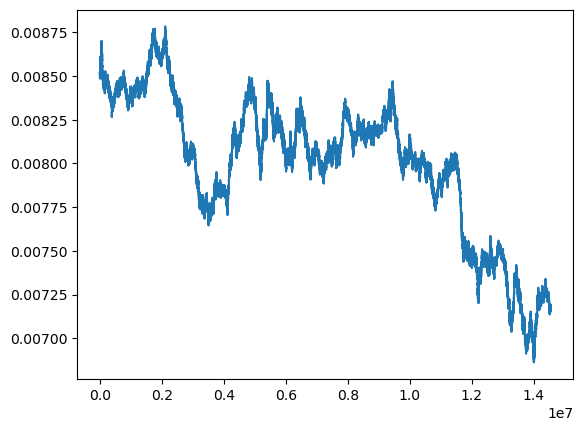

In [59]:
trades_pepe['price'].plot()


<Axes: >

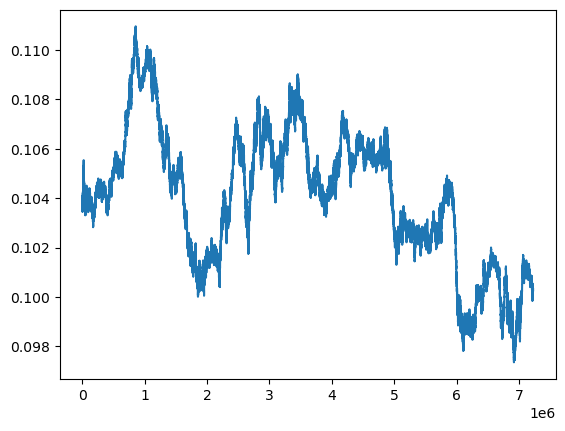

In [62]:
trades_dog['price'].plot()